# Model Evaluation and Visualisations

Simple to explore the embeddings decide which embedding to use.

In [4]:
import os
import json

from keras.layers import (
    Input,
    Embedding,
    Dot,
    Reshape,
    Dense
)
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE

ModuleNotFoundError: No module named 'keras'

In [2]:
sns.set(rc={'figure.figsize':(15, 10)})

NameError: name 'sns' is not defined

In [3]:
os.chdir('..')

First things first is to reload the data we need along with any functions

In [12]:
with open('games_with_tags_double_filter.json', 'r') as in_json:
    games_with_tags = json.load(in_json)

In [32]:
game_genre = {}
game_files = os.listdir('./data/games')
for game in game_files:
    with open(f'./data/games/{game}', 'r') as in_json:
        game_data = json.load(in_json)
        game_genre[game_data['name']] = game_data['genre']

In [13]:
game_index = {game: idx for idx, game in enumerate(games_with_tags)}
index_game = {idx: game for game, idx in game_index.items()}

In [14]:
tag_count = 0
tag_index = {}
for game, tags in games_with_tags.items():
    for tag in tags:
        if tag not in tag_index:
            tag_index[tag] = tag_count
            tag_count += 1
index_tag = {idx: tag for tag, idx in tag_index.items()}

In [62]:
def game_embedding_model(embedding_size = 100, classification = False):
    """Model to embed game and tags using the functional API.
       Trained to discern if a tag is present for a game"""
    
    game = Input(name = 'game', shape = [1])
    tag = Input(name = 'tag', shape = [1])
    
    game_embedding = Embedding(name = 'game_embedding',
                               input_dim = len(game_index),
                               output_dim = embedding_size)(game)
    
    tag_embedding = Embedding(name = 'tag_embedding',
                               input_dim = len(tag_index),
                               output_dim = embedding_size)(tag)
    
    merged = Dot(name = 'dot_product', normalize = True, axes = 2)([game_embedding, tag_embedding])
    
    merged = Reshape(target_shape = [1])(merged)
    
    model = Model(inputs = [game, tag], outputs = merged)
    model.compile(optimizer = 'Adam', loss = 'mse')
    
    return model

In [64]:
def extract_weights(name, model):
    """Extract weights from a neural network model"""
    
    # Extract weights
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    
    # Normalize
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

Load in the weights

In [67]:
m = game_embedding_model(embedding_size=50)
m_50 = m.load_weights('./models/double_filter_emb_50.h5')
game_weights_50 = extract_weights('game_embedding', m)
tag_weights_50 = extract_weights('tag_embedding', m)

m = game_embedding_model(embedding_size=100)
m_100 = m.load_weights('./models/double_filter_emb_100.h5')
game_weights_100 = extract_weights('game_embedding', m)
tag_weights_100 = extract_weights('tag_embedding', m)

m = game_embedding_model(embedding_size=150)
m_150 = m.load_weights('./models/double_filter_emb_150.h5')
game_weights_150 = extract_weights('game_embedding', m)
tag_weights_150 = extract_weights('tag_embedding', m)

m = game_embedding_model(embedding_size=200)
m_200 = m.load_weights('./models/double_filter_emb_200.h5')
game_weights_200 = extract_weights('game_embedding', m)
tag_weights_200 = extract_weights('tag_embedding', m)

Function which uses T-SNE to compression the embeddings into n components. By doing so it will allows us to visulaise the embeddings.

In [69]:
def reduce_dim(weights, components = 3):
    """
    Reduce dimensions of embeddings
    """
    return TSNE(components, metric = 'cosine').fit_transform(weights)

Compress the embeddings into two dimensions.

In [70]:
game_50_r = reduce_dim(game_weights_50, components = 2)
tag_50_r = reduce_dim(tag_weights_50, components = 2)

game_100_r = reduce_dim(game_weights_100, components = 2)
tag_100_r = reduce_dim(tag_weights_100, components = 2)

game_150_r = reduce_dim(game_weights_150, components = 2)
tag_150_r = reduce_dim(tag_weights_150, components = 2)

game_200_r = reduce_dim(game_weights_200, components = 2)
tag_200_r = reduce_dim(tag_weights_200, components = 2)

In [71]:
game_50_r.shape

(3027, 2)

In [115]:
Plot the compressed embeddings:

SyntaxError: invalid syntax (<ipython-input-115-0bd2b16bbdbe>, line 1)

Text(0.5, 1.0, 'Embedding Size: 200')

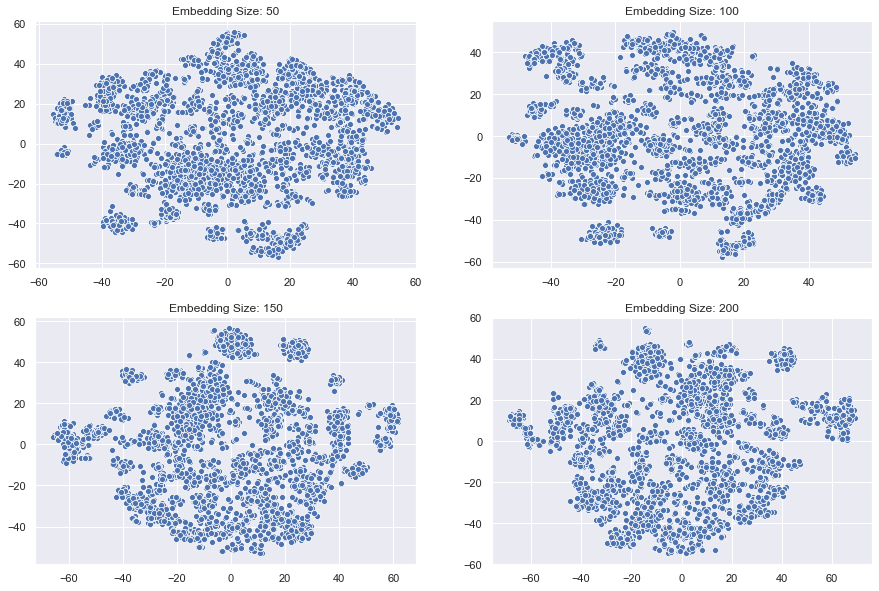

In [83]:
fig, axs = plt.subplots(nrows=2, ncols=2)
sns.scatterplot(game_50_r[:, 0], game_50_r[:, 1], ax=axs[0][0])
sns.scatterplot(game_100_r[:, 0], game_100_r[:, 1], ax=axs[0][1])
sns.scatterplot(game_150_r[:, 0], game_150_r[:, 1], ax=axs[1][0])
sns.scatterplot(game_200_r[:, 0], game_200_r[:, 1], ax=axs[1][1])
axs[0][0].set_title('Embedding Size: 50')
axs[0][1].set_title('Embedding Size: 100')
axs[1][0].set_title('Embedding Size: 150')
axs[1][1].set_title('Embedding Size: 200')

wow, lookes like we have clear clusters with the embeddings, can we identify what the clusters are?

This function colours the game if it contains a given tag.

In [89]:
def plot_tsne_with_tag(tag: str) -> None:
    """
    Plot the game embeddings with a tag coloured
    
    :type tag: str
    :param tag: Tag to highlight in plot
    :rtype: None
    """
    fig, axs = plt.subplots(nrows=2, ncols=2)
    plt.title(f'T-NSE plot with {tag} Highlighted')
    sns.scatterplot(
        game_50_r[:, 0],
        game_50_r[:, 1],
        hue=[tag if tag in i else 0 for i in games_with_tags.values()],
        ax=axs[0][0]
    )
    sns.scatterplot(
        game_100_r[:, 0],
        game_100_r[:, 1],
        hue=[tag if tag in i else 0 for i in games_with_tags.values()],
        ax=axs[0][1]
    )
    sns.scatterplot(
        game_150_r[:, 0],
        game_150_r[:, 1],
        hue=[tag if tag in i else 0 for i in games_with_tags.values()],
        ax=axs[1][0]
    )
    sns.scatterplot(
        game_200_r[:, 0],
        game_200_r[:, 1],
        hue=[tag if tag in i else 0 for i in games_with_tags.values()],
        ax=axs[1][1]
    )
    axs[0][0].set_title('Embedding Size: 50')
    axs[0][1].set_title('Embedding Size: 100')
    axs[1][0].set_title('Embedding Size: 150')
    axs[1][1].set_title('Embedding Size: 200')

Take a look at `Fantast` first:

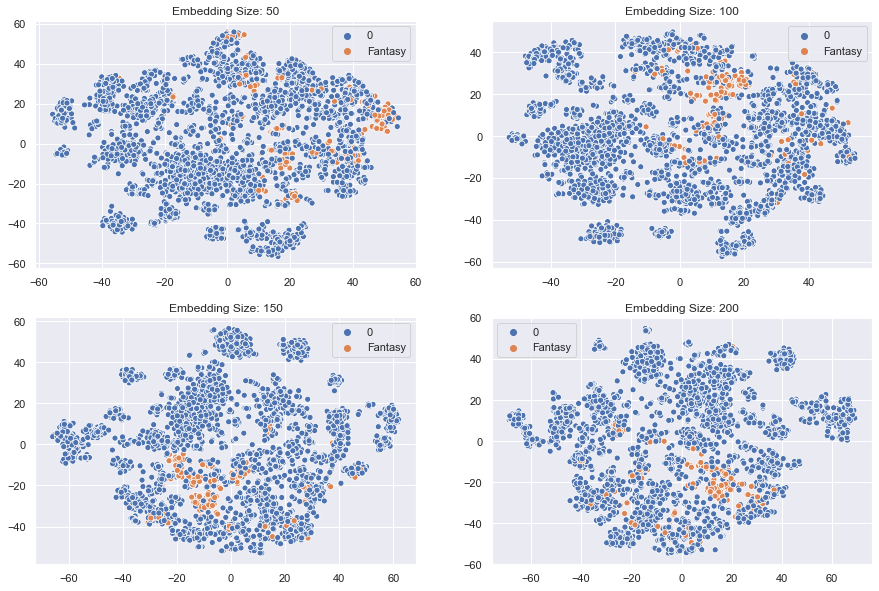

In [92]:
plot_tsne_with_tag('Fantasy')

No clear cluster which makes sense, as fantasy games are typically associated with many different tags.

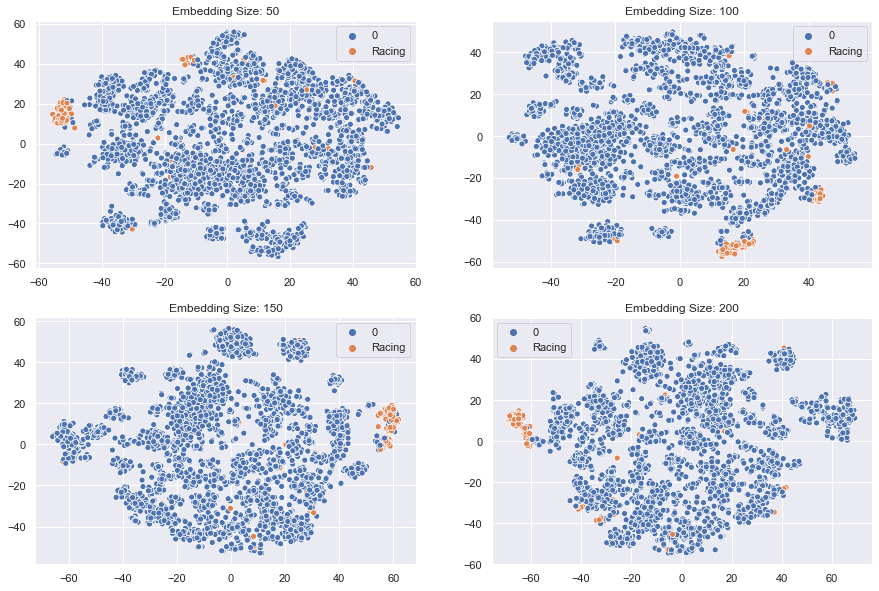

In [93]:
plot_tsne_with_tag('Racing')

Here, we have clear clusters. The `Racing` tag has a much smaller subset of games it can belong illustrated by the clusters of the racing games.

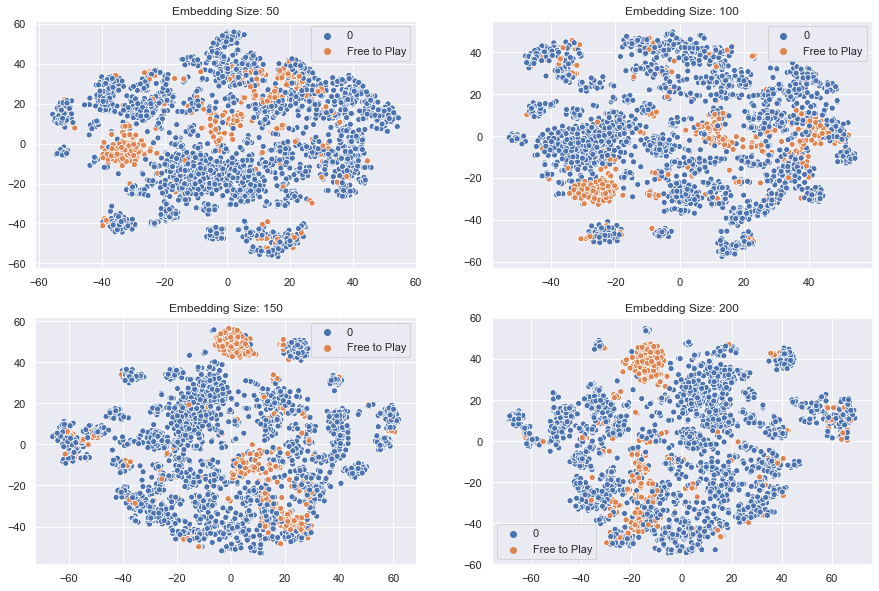

In [90]:
plot_tsne_with_tag('Free to Play')

Now let's repeat this but with the tag embeddings.

In [25]:
tag_r = reduce_dim(tag_weights, components = 2, method = 'tsne')
tag_r.shape

(151, 2)

Text(0.5, 1.0, 'Tag Embedding Size: 200')

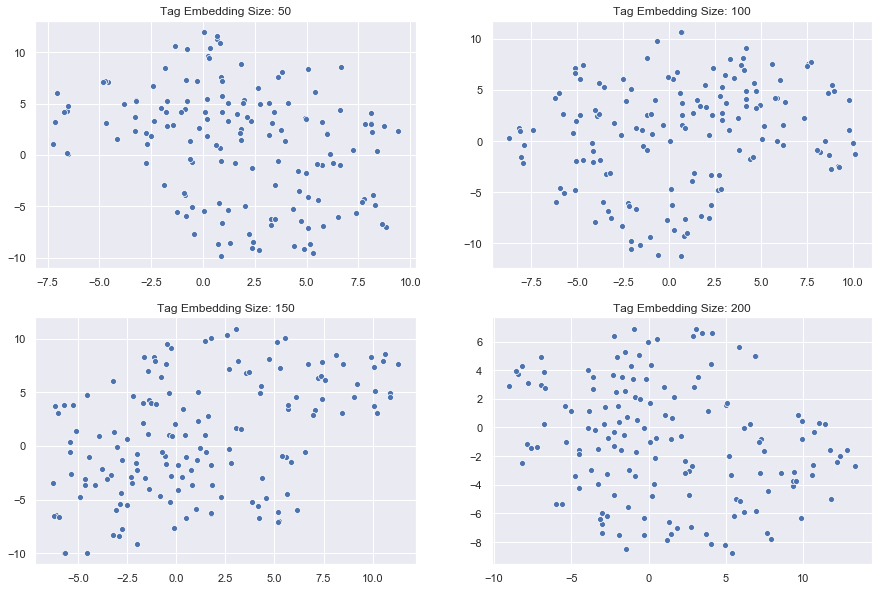

In [86]:
fig, axs = plt.subplots(nrows=2, ncols=2)
sns.scatterplot(tag_50_r[:, 0], tag_50_r[:, 1], ax=axs[0][0])
sns.scatterplot(tag_100_r[:, 0], tag_100_r[:, 1], ax=axs[0][1])
sns.scatterplot(tag_150_r[:, 0], tag_150_r[:, 1], ax=axs[1][0])
sns.scatterplot(tag_200_r[:, 0], tag_200_r[:, 1], ax=axs[1][1])
axs[0][0].set_title('Tag Embedding Size: 50')
axs[0][1].set_title('Tag Embedding Size: 100')
axs[1][0].set_title('Tag Embedding Size: 150')
axs[1][1].set_title('Tag Embedding Size: 200')

Nothing really to make from this.

Let's look at the differences in recommendations including ones make when subtracting or adding a tag.

In [94]:
def find_closest(game_embedding: np.array) -> None:
    """
    Finds the closest games in the embedding based on cosine distance
    
    :type game_embedding: np.array
    :param game_embedding: Embedding of game to find recommendaions for
    """
    dists = np.dot(game_weights, game_embedding)
    sorted_dists = np.argsort(dists)
    closest = sorted_dists[-6:]
    for c in reversed(closest):
        print(f'GAME: {index_game[c]:{40}} Similarity: {dists[c]:.{2}}')

def subtract_tag(tag: str, game: str) -> np.array:
    """
    Subtracts a tag embedding from a game embedding and normalises
    
    :type tag: str
    :param tag: Tag to subtract from game embedding
    :type game: str
    :param game: Game which tag embedding is subtracted from
    :rtype: np.array
    :return: New game array with the tag embedding removed
    """
    new_game_weight = game_weights[game_index[game]] - tag_weights[tag_index[tag]]
    return new_game_weight / np.linalg.norm(new_game_weight).reshape((-1, 1))[0]

def add_tag(tag: str, game: str) -> np.array:
    """
    Adds a tag embedding from a game embedding and normalises
    
    :type tag: str
    :param tag: Tag to add to game embedding
    :type game: str
    :param game: Game which tag embedding is added to
    :rtype: np.array
    :return: New game array with the tag embedding added
    """
    new_game_weight = game_weights[game_index[game]] + tag_weights[tag_index[tag]]
    return new_game_weight / np.linalg.norm(new_game_weight).reshape((-1, 1))[0]

In [111]:
def subtract_tag_recommendations(tag: str, game: str):
    """
    Returns a list of the top 10 recommended games across all the
    embeddings via subtracting a given tag
    
    :type tag: str
    :param tag: Tag to subtract from game embedding
    :type game: str
    :param game: Game which tag embedding is subtracted from
    :rtype: np.array
    :return: New game array with the tag embedding removed
    """
    data = []
    pairs = [
        [game_weights_50, tag_weights_50, 'Game Embedding 50'],
        [game_weights_100, tag_weights_100, 'Game Embedding 100'],
        [game_weights_150, tag_weights_150, 'Game Embedding 150'],
        [game_weights_200, tag_weights_200, 'Game Embedding 200'],
    ]
    for ge, te, name in pairs:
        new_game_weight = ge[game_index[game]] - te[tag_index[tag]]
        new_game_weight = new_game_weight / np.linalg.norm(new_game_weight).reshape((-1, 1))[0]
        
        dists = np.dot(ge, new_game_weight)
        sorted_dists = np.argsort(dists)
        closest = sorted_dists[-6:]
        for c in reversed(closest):
            data.append([name, index_game[c], dists[c]])
    return pd.DataFrame(data, columns=['Embedding', 'Game', 'Similarity'])

def add_tag_recommendations(tag: str, game: str):
    """
    Returns a list of the top 10 recommended games across all the
    embeddings via subtracting a given tag
    
    :type tag: str
    :param tag: Tag to subtract from game embedding
    :type game: str
    :param game: Game which tag embedding is subtracted from
    :rtype: np.array
    :return: New game array with the tag embedding removed
    """
    data = []
    pairs = [
        [game_weights_50, tag_weights_50, 'Game Embedding 50'],
        [game_weights_100, tag_weights_100, 'Game Embedding 100'],
        [game_weights_150, tag_weights_150, 'Game Embedding 150'],
        [game_weights_200, tag_weights_200, 'Game Embedding 200'],
    ]
    for ge, te, name in pairs:
        new_game_weight = ge[game_index[game]] + te[tag_index[tag]]
        new_game_weight = new_game_weight / np.linalg.norm(new_game_weight).reshape((-1, 1))[0]
        
        dists = np.dot(ge, new_game_weight)
        sorted_dists = np.argsort(dists)
        closest = sorted_dists[-6:]
        for c in reversed(closest):
            data.append([name, index_game[c], dists[c]])
    return pd.DataFrame(data, columns=['Embedding', 'Game', 'Similarity'])

In [107]:
subtract_tag_recommendations('Fantasy', 'Age of Mythology: Extended Edition')

,Embedding,Game,Similarity
0,Game Embedding 50,Ultimate General: Civil War,0.829070
1,Game Embedding 50,Call of Duty 2,0.816418
2,Game Embedding 50,Steel Division: Normandy 44,0.808922
3,Game Embedding 50,Takedown: Red Sabre,0.807476
4,Game Embedding 50,ARMA: Cold War Assault,0.807312
5,Game Embedding 50,Wargame: Red Dragon,0.803514
6,Game Embedding 100,ARMA: Cold War Assault,0.859876
7,Game Embedding 100,"Warhammer 40,000: Dawn of War II",0.821104
8,Game Embedding 100,Wargame: Red Dragon,0.818554
9,Game Embedding 100,Rise of Nations: Extended Edition,0.817954


In [110]:
subtract_tag_recommendations('Sci-fi', 'Stellaris')

,Embedding,Game,Similarity
0,Game Embedding 50,PC Building Simulator,0.788093
1,Game Embedding 50,My Time At Portia,0.781592
2,Game Embedding 50,Poly Bridge,0.776380
3,Game Embedding 50,Niche - a genetics survival game,0.771319
4,Game Embedding 50,Train Simulator 2020,0.770342
5,Game Embedding 50,Universe Sandbox Legacy,0.769740
6,Game Embedding 100,RollerCoaster Tycoon World,0.770738
7,Game Embedding 100,Staxel,0.757920
8,Game Embedding 100,Turmoil,0.757131
9,Game Embedding 100,Railroad Corporation,0.755682


In [113]:
add_tag_recommendations('Fantasy', 'Stellaris')

,Embedding,Game,Similarity
0,Game Embedding 50,Stellaris,0.803712
1,Game Embedding 50,Dragon's Dogma: Dark Arisen,0.741613
2,Game Embedding 50,DARK SOULS III,0.725970
3,Game Embedding 50,The Elder Scrolls IV: Oblivion Game of the Yea...,0.724889
4,Game Embedding 50,The Elder Scrolls V: Skyrim,0.705489
5,Game Embedding 50,Endless Space 2,0.695466
6,Game Embedding 100,Stellaris,0.746496
7,Game Embedding 100,STAR WARS - Knights of the Old Republic,0.743596
8,Game Embedding 100,The Elder Scrolls V: Skyrim,0.720542
9,Game Embedding 100,The Elder Scrolls III: Morrowind Game of the Y...,0.677420


In [114]:
add_tag_recommendations('Sci-fi', 'Age of Mythology: Extended Edition')

,Embedding,Game,Similarity
0,Game Embedding 50,Age of Mythology: Extended Edition,0.860686
1,Game Embedding 50,Sid Meier's Civilization: Beyond Earth,0.828251
2,Game Embedding 50,Homeworld Remastered Collection,0.799422
3,Game Embedding 50,XCOM 2,0.784833
4,Game Embedding 50,Natural Selection 2,0.778827
5,Game Embedding 50,"Star Wars: Battlefront 2 (Classic, 2005)",0.776598
6,Game Embedding 100,Age of Mythology: Extended Edition,0.823364
7,Game Embedding 100,"Star Wars: Battlefront 2 (Classic, 2005)",0.790733
8,Game Embedding 100,XCOM: Enemy Unknown,0.782756
9,Game Embedding 100,Homeworld Remastered Collection,0.779109


I like the look and feel of the largest embedding (200) so this will be used in the API. It seems to have "learnt" the relationship the best and makes generally sensible recommendations in both the normal sense and when the embeddings are manipulated. 